Installing np_utils for Keras

In [1]:
pip install np_utils

Note: you may need to restart the kernel to use updated packages.


Importing libraries for this project

In [123]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import cv2, os, gc, glob
from tensorflow.keras import layers, models
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.utils import load_img
import random
from tensorflow import keras

# Input Data Preprocessing

Importing Input Dataset

In [23]:
dataset_path="DataSet/COVID-19_Radiography_Dataset"

In [25]:
image_path=[]
#Getting list of all image paths using os.walk function
for (directory, folder, files) in os.walk(dataset_path): 
    for name in files:
        if (name[-3:]=='png'): 
          #Combining paths to all images into one variable
            image_path.append(os.path.join(directory, name)) 

Creating labels that will be used to tag images [Image Name : Label]

In [26]:
input=[]
target=[]
resize=150

dictionary={'Viral Pneumonia': 'Pneumonia', 'Normal': 'Normal', 'COVID': 'Covid-19'} 

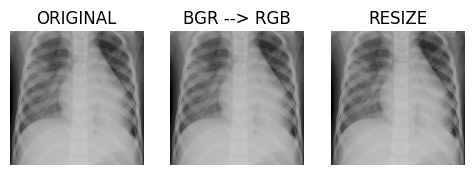

In [45]:
imgpath = image_path[0]
label=imgpath.split(os.path.sep)[-2]
image=cv2.imread(imgpath)
plt.figure(figsize=(10,10))
plt.subplot(4,5,1)
plt.title("ORIGINAL")
plt.imshow(image)
plt.axis('off') 
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.subplot(4,5,2)
plt.title("BGR --> RGB")
plt.imshow(image)
plt.axis('off') 
image=cv2.resize(image, (resize, resize)) /255 #resizing the image
plt.subplot(4,5,3)
plt.title("RESIZE")
plt.imshow(image)
plt.axis('off')  
plt.show()

Performing processing on the input images

In [7]:
for path in tqdm(image_path):
    label=path.split(os.path.sep)[-2]
    image=cv2.imread(path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image=cv2.resize(image, (resize, resize)) /255

    #Map each input to a label and add it to the input array
    input.append(image)
    target.append(dictionary[label])

100%|████████████████████████████████████| 15153/15153 [00:23<00:00, 647.35it/s]


Creating a dataframe of labels

In [8]:
df=pd.DataFrame(target,columns=['labels'])

In [10]:
size=[]
for file in image_path: #Iterating through all images
    img=cv2.imread(file) #Read each image
    size.append(img.shape)
pd.Series(size).value_counts() #Printing details about image (channels, size)


(299, 299, 3)    15153
dtype: int64

Encoding class labels to integral variables



In [11]:
#Normalize the class labels
enc=LabelEncoder() 
labels=enc.fit_transform(target)
labels=to_categorical(labels)
#Printing the encoding mapping
print(enc.classes_)
print(labels[0])

['Covid-19' 'Normal' 'Pneumonia']
[0. 0. 1.]


# Setting up the CNN Model

Creating testing and training partitions from input dataset

In [12]:
(trainX, testX, trainY, testY)=train_test_split(input, labels, test_size=0.20, stratify=labels, random_state=42)

trainX=np.array(trainX)
testX=np.array(testX)
trainY=np.array(trainY)
testY=np.array(testY)

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(12122, 150, 150, 3)
(3031, 150, 150, 3)
(12122, 3)
(3031, 3)


In [13]:
from tensorflow.keras import backend as K
K.clear_session()

Creating the CNN Model

In [14]:
s=150
model=Sequential()
model.add(Conv2D(filters=8, kernel_size=(3,3), activation="relu", input_shape=(s,s,3), kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(1,1)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))

2022-12-07 18:32:27.344350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-07 18:32:27.345722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


Compiling the CNN model

In [15]:
model.compile(optimizer=Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
tf.config.run_functions_eagerly(True)

In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        4672      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 33, 33, 128)      0

In [17]:
input=[]
image_path=[]
df=[]
size=[]

Training the CNN Model

In [20]:
epochs=20
batch_size=64
trained_model=model.fit(trainX, trainY, batch_size, validation_data=(testX, testY), epochs=20)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 2s 2s/step - loss: 1.0961 - accuracy: 0.3750 - val_loss: 1.5537 - val_accuracy: 0.3333
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 1.7419 - accuracy: 0.3750 - val_loss: 4.0589 - val_accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.9239 - accuracy: 0.3333 - val_loss: 1.6725 - val_accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 1.4198 - accuracy: 0.5000 - val_loss: 1.1222 - val_accuracy: 0.3333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 0.8874 - accuracy: 0.5000 - val_loss: 1.0062 - val_accuracy: 0.6667
Epoch 6/20
1/1 [==============================] - 1s 1s/step - loss: 0.8220 - accuracy: 0.6250 - val_loss: 1.0413 - val_accuracy: 0.6667
Epoch 7/20
1/1 [==============================] - 1s 1s/step - loss: 0.7362 - accuracy: 0.8333 - val_loss: 1.1787 - val_accuracy: 0.6667
Epoch 8/20
1/1 [==============================] - 1s

In [32]:
model.save('CPN_Model.h5')

# Result Metrics

Checking the Test Accuracy of the Model

In [22]:
test_loss, test_accuracy=model.evaluate(testX, testY, verbose=0)
print('Value of Test Loss is: {}'.format(test_loss))
print('Value of Test Accuracy is: {}'.format(test_accuracy))

Value of Test Loss is: 6.909788608551025
Value of Test Accuracy is: 0.8333333134651184


Classification Report on Training Dataset

In [23]:
prediction_matrix = model.predict (trainX, batch_size=64)
prediction_matrix = np.argmax(prediction_matrix, axis=1)
print(classification_report(trainY.argmax(axis=1), prediction_matrix, target_names=enc.classes_, digits=3))

1/1 [==============================] - 0s 274ms/step
              precision    recall  f1-score   support

    Covid-19      1.000     1.000     1.000         8
      Normal      1.000     1.000     1.000         8
   Pneumonia      1.000     1.000     1.000         8

    accuracy                          1.000        24
   macro avg      1.000     1.000     1.000        24
weighted avg      1.000     1.000     1.000        24



Classification Report on Testing Dataset

In [25]:
prediction_matrix=model.predict(testX, batch_size=64)
prediction_matrix=np.argmax(prediction_matrix, axis=1)
print(classification_report(testY.argmax(axis=1), prediction_matrix, target_names=enc.classes_, digits=3))

1/1 [==============================] - 0s 96ms/step
              precision    recall  f1-score   support

    Covid-19      1.000     0.500     0.667         2
      Normal      1.000     1.000     1.000         2
   Pneumonia      0.667     1.000     0.800         2

    accuracy                          0.833         6
   macro avg      0.889     0.833     0.822         6
weighted avg      0.889     0.833     0.822         6



/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


# DEMO FOR THE MODEL

In [127]:
model=keras.models.load_model('SavedModel/CPN_Model.h5')

In [139]:
#PICK A RANDOM IMAGE FROM DATASET
num = random.randrange(0, 1000)
covid_img_path="DataSet/COVID-19_Radiography_Dataset/COVID/COVID-"+ str(num) +".png"
normal_img_path="DataSet/COVID-19_Radiography_Dataset/Normal/Normal-"+ str(num) +".png"
pneumonia_img_path="DataSet/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-"+ str(num) +".png"


#Preprocessing the input images
img_paths=[covid_img_path, normal_img_path, pneumonia_img_path]
actual = ['Actual : COVID-19',' Actual : Normal',' Actual : Pneumonia']
resize=150
images=[]

for img_path in img_paths:
  img_path=cv2.imread(img_path)
  img_path=cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB) 
  img_path=cv2.resize(img_path, (resize, resize)) /255
  images.append(img_path)


#Checking the shape of the input images

count=0
for i in images:
  images[count]=np.array(images[count])
  images[count]=np.expand_dims(images[count], axis=0)
  print(images[count].shape)
  count+=1

(1, 150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)


Predicting the output class of the images

1/1 [==============================] - 0s 12ms/step


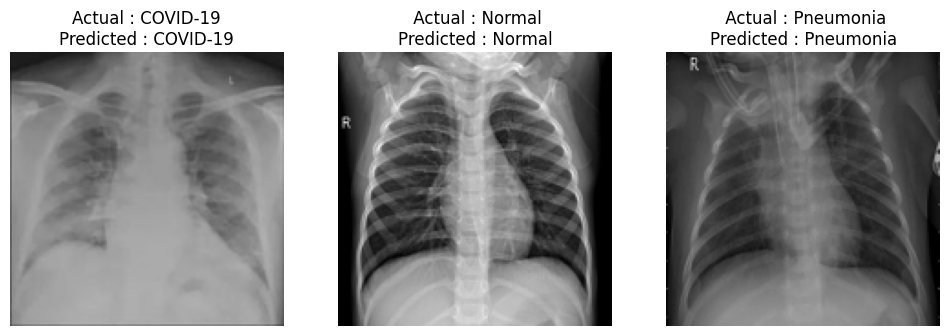

In [140]:
prediction=[]
for i in images:
  prediction.append(model.predict(i))
output=[]
for p in prediction:
  output.append(np.argmax(p,axis=1))
title=[]

for x in output:
  if x==0:
    title.append('Predicted : COVID-19')
  elif x==1:
    title.append('Predicted : Normal')
  else:
    title.append('Predicted : Pneumonia')

#PLOT The OUTPUT
plt.figure(figsize=(12,12))

i=0

for img in images:
  plt.subplot(1,3,i+1)
  plt.imshow(np.squeeze(img) , cmap='gray')
  plt.title(actual[i] + "\n"+ title[i])
  plt.axis('off')  
  i+=1   
plt.show()